# Mesa Introductory Tutorial

This tutorial has been adapted from the Mesa package introductory tutorial [GitHub](https://github.com/projectmesa/mesa/blob/main/docs/tutorials/intro_tutorial.rst)

## Description

[Mesa](https://github.com/projectmesa/mesa) is a Python framework for
[agent-based modeling](https://en.wikipedia.org/wiki/Agent-based_model). Getting
started with Mesa is easy. In this tutorial, we will walk through
creating a simple model and progressively add functionality which will
illustrate Mesa’s core features.

The base for this tutorial is a very simple model of agents exchanging
money. Next, we add *space* to allow agents to move. Then, we’ll cover
two of Mesa’s analytic tools: the *data collector* and *batch runner*.
After that, we’ll add an *interactive visualization* which lets us watch
the model as it runs. Finally, we go over how to write your own
visualization module.

You can also find all the code this tutorial describes in the
**examples/boltzmann_wealth_model** directory of the Mesa repository.

## Sample Model Description

The tutorial model is a very simple simulated agent-based economy, drawn
from econophysics and presenting a statistical mechanics approach to
wealth distribution [Dragulescu2002]. The rules of our tutorial model:

1. There are some number of agents.
2. All agents begin with 1 unit of money.
3. At every step of the model, an agent gives 1 unit of money (if they
   have it) to some other agent.

Despite its simplicity, this model yields results that are often
unexpected to those not familiar with it. For our purposes, it also
easily demonstrates Mesa’s core features.

Let’s get started.

[Dragulescu2002] Drăgulescu, Adrian A., and Victor M. Yakovenko. “Statistical Mechanics of Money, Income, and Wealth: A Short Survey.”arXiv Preprint Cond-mat/0211175, 2002. http://arxiv.org/abs/cond-mat/0211175.

## Building a sample model

Once Mesa is installed, you can start building our model. You can write
models interactively in [Jupyter Notebook](http://jupyter.org/) cells.

## Setting up the model

To begin writing the model code, we start with two core classes: one for
the overall model, the other for the agents. The model class holds the
model-level attributes, manages the agents, and generally handles the
global level of our model. Each instantiation of the model class will be
a specific model run. Each model will contain multiple agents, all of
which are instantiations of the agent class. Both the model and agent
classes are child classes of Mesa’s generic ``Model`` and ``Agent``
classes.

Each agent has only one variable: how much wealth it currently has.
(Each agent will also have a unique identifier (i.e., a name), stored in
the ``unique_id`` variable. Giving each agent a unique id is a good
practice when doing agent-based modeling.)

There is only one model-level parameter: how many agents the model
contains. When a new model is started, we want it to populate itself
with the given number of agents.

The beginning of both classes looks like this:

In [1]:
# Setting up the model

from mesa import Agent, Model

class MoneyAgent(Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1


class MoneyModel(Model):
    """A model with some number of agents."""

    def __init__(self, N):
        self.num_agents = N
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)

In [2]:
# Adding the scheduler

from mesa import Agent, Model
from mesa.time import RandomActivation


class MoneyAgent(Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def step(self):
        # The agent's step will go here.
        # For demonstration purposes we will print the agent's unique_id
        print("Hi, I am agent " + str(self.unique_id) + ".")


class MoneyModel(Model):
    """A model with some number of agents."""

    def __init__(self, N):
        self.num_agents = N
        self.schedule = RandomActivation(self)
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)

    def step(self):
        """Advance the model by one step."""
        self.schedule.step()

In [3]:
# Test the model

empty_model = MoneyModel(10)
empty_model.step()

Hi, I am agent 7.
Hi, I am agent 2.
Hi, I am agent 6.
Hi, I am agent 4.
Hi, I am agent 3.
Hi, I am agent 9.
Hi, I am agent 8.
Hi, I am agent 5.
Hi, I am agent 1.
Hi, I am agent 0.


In [4]:
# Agent Step

class MoneyAgent(Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def step(self):
        if self.wealth == 0:
            return
        other_agent = self.random.choice(self.model.schedule.agents)
        other_agent.wealth += 1
        self.wealth -= 1

In [5]:
# Test the model

model = MoneyModel(10)
for i in range(10):
    model.step()

(array([6., 0., 0., 0., 0., 0., 2., 0., 0., 2.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

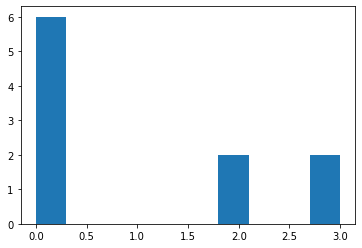

In [6]:
# Show results
# For a jupyter notebook add the following line:
%matplotlib inline

# The below is needed for both notebooks and scripts
import matplotlib.pyplot as plt

agent_wealth = [a.wealth for a in model.schedule.agents]
plt.hist(agent_wealth)

(array([421., 328., 140.,  67.,  33.,   8.,   3.]),
 array([0, 1, 2, 3, 4, 5, 6, 7]),
 <BarContainer object of 7 artists>)

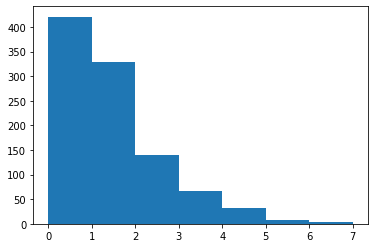

In [7]:
# Ploting sampling distribution

all_wealth = []
# This runs the model 100 times, each model executing 10 steps.
for j in range(100):
    # Run the model
    model = MoneyModel(10)
    for i in range(10):
        model.step()

    # Store the results
    for agent in model.schedule.agents:
        all_wealth.append(agent.wealth)

plt.hist(all_wealth, bins=range(max(all_wealth) + 1))

In [8]:
# Adding space

from mesa.space import MultiGrid

class MoneyAgent(Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other_agent = self.random.choice(cellmates)
            other_agent.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()


class MoneyModel(Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

    def step(self):
        self.schedule.step()

In [9]:
# Test the model

model = MoneyModel(50, 10, 10)
for i in range(20):
    model.step()

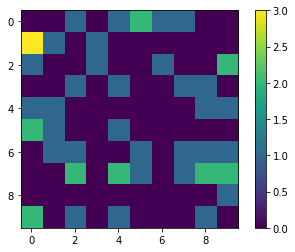

In [10]:
# Show the data in grid

import numpy as np

agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation="nearest")
plt.colorbar()

# If running from a text editor or IDE, remember you'll need the following:
# plt.show()

In [11]:
# Collecting Data

from mesa.datacollection import DataCollector


def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B


class MoneyAgent(Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()


class MoneyModel(Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [12]:
# Test the model

model = MoneyModel(50, 10, 10)
for i in range(100):
    model.step()

<AxesSubplot:>

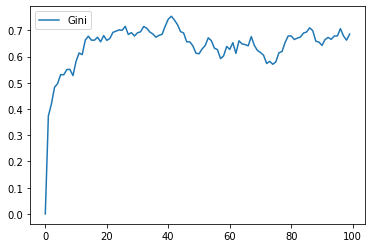

In [14]:
# Plot coefficients

gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

In [15]:
# Get agent data
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.head()

Wealth
Step AgentID        
0    0             1
     1             1
     2             1
     3             1
     4             1

<AxesSubplot:>

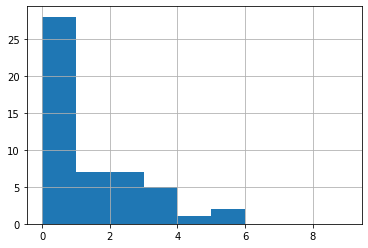

In [16]:
# Plot histogram of agents wealth

end_wealth = agent_wealth.xs(99, level="Step")["Wealth"]
end_wealth.hist(bins=range(agent_wealth.Wealth.max() + 1))

<AxesSubplot:xlabel='Step'>

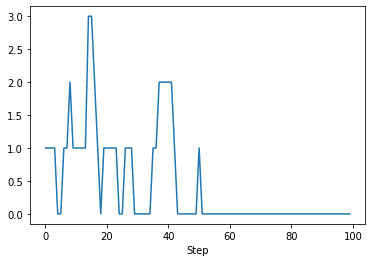

In [17]:
# Plot the trend of wealth of given agent

one_agent_wealth = agent_wealth.xs(14, level="AgentID")
one_agent_wealth.Wealth.plot()

In [18]:
# Batch Run

def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B


class MoneyAgent(Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()


class MoneyModel(Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.running = True

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [19]:
# Test the batch model

from mesa.batchrunner import batch_run

params = {"width": 10, "height": 10, "N": range(10, 500, 10)}

results = batch_run(
    MoneyModel,
    parameters=params,
    iterations=5,
    max_steps=100,
    number_processes=None,
    data_collection_period=1,
    display_progress=True,
)

245it [00:14, 16.87it/s]


In [20]:
# Collect batch data as Pandas dataframe

import pandas as pd

results_df = pd.DataFrame(results)
print(results_df.keys())

Index(['RunId', 'iteration', 'Step', 'width', 'height', 'N', 'Gini', 'AgentID',
       'Wealth'],
      dtype='object')


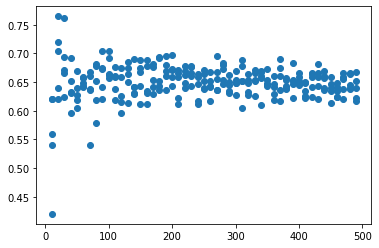

In [21]:
# Trend of coefficients after each iteration

results_filtered = results_df[(results_df.AgentID == 0) & (results_df.Step == 100)]
N_values = results_filtered.N.values
gini_values = results_filtered.Gini.values
plt.scatter(N_values, gini_values)

In [24]:
# Show agent’s wealth at each time step of one specific episode

# First, we filter the results
one_episode_wealth = results_df[(results_df.N == 10) & (results_df.iteration == 2)]
# Then, print the columns of interest of the filtered data frame
# print(one_episode_wealth.to_string(index=False, columns=["Step", "AgentID", "Wealth"]))
# For a prettier display we can also convert the data frame to html, uncomment to test in a Jupyter Notebook
from IPython.display import display, HTML
display(HTML(one_episode_wealth.to_html(index=False, columns=['Step', 'AgentID', 'Wealth'], max_rows=25)))


Step,AgentID,Wealth
0,0,1
0,1,1
0,2,1
0,3,1
0,4,1
0,5,1
0,6,1
0,7,1
0,8,1
0,9,1


In [25]:
# Development of the coefficient over the course of one iteration

results_one_episode = results_df[
    (results_df.N == 10) & (results_df.iteration == 1) & (results_df.AgentID == 0)
]
print(results_one_episode.to_string(index=False, columns=["Step", "Gini"], max_rows=25))


 Step  Gini
    0  0.00
    1  0.00
    2  0.32
    3  0.42
    4  0.42
    5  0.42
    6  0.42
    7  0.42
    8  0.42
    9  0.42
   10  0.42
   11  0.42
  ...   ...
   89  0.54
   90  0.58
   91  0.58
   92  0.58
   93  0.58
   94  0.62
   95  0.62
   96  0.62
   97  0.62
   98  0.62
   99  0.54
  100  0.54
